# Position processing for Berke Lab!

Adapted from Xulu's position processing and 20_Position_Trodes.ipynb

### Overview


In this tutorial, we'll process position data extracted with Trodes Tracking by

- Defining parameters
- Processing raw position
- Extracting centroid and orientation
- Insert the results into the `TrodesPosV1` table
- Plotting the head position/direction results for quality assurance

The pipeline takes the 2D video pixel data of green/red LEDs, and computes:

- head position (in cm)
- head orientation (in radians)
- head velocity (in cm/s)
- head speed (in cm/s)


## Loading the data

First, make sure that the session we want to analyze is inserted into the `RawPosition` table


In [1]:
import spyglass.common as sgc
import spyglass.position as sgp
from spyglass.position.v1 import get_video_info
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common import CameraDevice
import datajoint as dj
import matplotlib.pyplot as plt
from hex_maze_behavior import populate_all_hexmaze

# ignore datajoint+jupyter async warnings
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)

# Define file name - should have already been inserted using sgi.insert_sessions(nwb_file_name)
nwb_file_name = "IM-1478_20220725.nwb"
#nwb_file_name = "BraveLu20240516.nwb"

nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
sgc.common_behav.RawPosition() & {"nwb_file_name": nwb_copy_file_name}

#populate_all_hexmaze(nwb_copy_file_name)
#(CameraDevice())# & {'camera_name': "maze_camera"})


camera_devices = CameraDevice() & 'camera_name LIKE "%maze%"'
display(camera_devices)

# Filter for the first run epoch (aka epoch tag includes 'r1')
valid_intervals = sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name} & 'interval_list_name LIKE "%r1%"'
display(valid_intervals)
#get_video_info({'nwb_file_name': nwb_copy_file_name})

ModuleNotFoundError: No module named 'spyglass'

## Setting parameters


Parameters are set by the `TrodesPosParams` table, with a `default` set
available. To adjust the default, insert a new set into this table. The
parameters are...

- `max_separation`, default 9 cm: maximum acceptable distance between red and
  green LEDs.
  - If exceeded, the times are marked as NaNs and inferred by interpolation.
  - Useful when the inferred LED position tracks a reflection instead of the
    true position.
- `max_speed`, default 300.0 cm/s: maximum speed the animal can move.
  - If exceeded, times are marked as NaNs and inferred by interpolation.
  - Useful to prevent big jumps in position.
- `position_smoothing_duration`, default 0.100 s: LED position smoothing before
  computing average position to get head position.
- `speed_smoothing_std_dev`, default 0.100 s: standard deviation of the Gaussian
  kernel used to smooth the head speed.
- `front_led1`, default 1 (True), use `xloc`/`yloc`: Which LED is the front LED
  for calculating the head direction.
  - 1: LED corresponding to `xloc`, `yloc` in the `RawPosition` table is the
    front, `xloc2`, `yloc2` as the back.
  - 0: LED corresponding to `xloc2`, `yloc2` in the `RawPosition` table is the
    front, `xloc`, `yloc` as the back.

We can see these defaults with `TrodesPosParams().default_params`.


In [2]:
sgp.v1.TrodesPosParams()

trodes_pos_params_name name for this set of parameters,params
decoding_xs,=BLOB=
default,=BLOB=
default_decoding,=BLOB=
default_decoding_4ms,=BLOB=
default_led0,=BLOB=
default_lowerspeed,=BLOB=
default_speed35,=BLOB=
dlc_head_body,=BLOB=
double_led,=BLOB=
double_led_CD,=BLOB=


In [6]:
# Take a look at the default params.
(sgp.v1.TrodesPosParams() & {'trodes_pos_params_name':'default'}).fetch('params')


array([{'max_separation': 9.0, 'max_speed': 300.0, 'position_smoothing_duration': 0.125, 'speed_smoothing_std_dev': 0.1, 'orient_smoothing_std_dev': 0.001, 'led1_is_front': 1, 'is_upsampled': 0, 'upsampling_sampling_rate': None, 'upsampling_interpolation_method': 'linear'}],
      dtype=object)

If we have only one LED (or for Berke Lab, only one point tracked by DLC), we can use the following params. 

These are the same as the 'default' params but the `max_separation` field is much bigger (we can't enforce a small separation between 2 points when we only have one)

In [ ]:
# This is also a good example for how to add custom parameters!
trodes_params_name = "single_led"
trodes_params = {
    "max_separation": 10000.0,
    "max_speed": 300.0,
    "position_smoothing_duration": 0.125,
    "speed_smoothing_std_dev": 0.1,
    "orient_smoothing_std_dev": 0.001,
    "led1_is_front": 1,
    "is_upsampled": 0,
    "upsampling_sampling_rate": None,
    "upsampling_interpolation_method": "linear",
}

sgp.v1.TrodesPosParams.insert1(
    {
        "trodes_pos_params_name": trodes_params_name,
        "params": trodes_params,
    },
    skip_duplicates=True,
)
sgp.v1.TrodesPosParams()

trodes_pos_params_name name for this set of parameters,params
decoding_xs,=BLOB=
default,=BLOB=
default_decoding,=BLOB=
default_decoding_4ms,=BLOB=
default_led0,=BLOB=
default_lowerspeed,=BLOB=
default_speed35,=BLOB=
dlc_head_body,=BLOB=
double_led,=BLOB=
double_led_CD,=BLOB=


## Select interval


Later, we'll pair the above parameters with an interval from our NWB file and
insert into `TrodesPosSelection`.

First, let's select an interval from the `IntervalList` table.


In [32]:
interval_list_names = ["00_r1", "01_r1"]
interval_list_name_condition = [{'interval_list_name': name} for name in interval_list_names]

valid_intervals = (sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name} & interval_list_name_condition)
valid_intervals

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start/end times for each interval,"pipeline type of interval list (e.g. 'position', 'spikesorting_recording_v1')"
BraveLu20240516_.nwb,01_r1,=BLOB=,


The raw position in pixels is in the `RawPosition` table is extracted from the
video data by the algorithm in Trodes (for Frank Lab) or imported from DLC (Berke Lab). 
We have timepoints available for the
duration when position tracking was turned on and off, which may be a subset of
the video itself.

`fetch1_dataframe` returns the position of the LEDs as a pandas dataframe where
time is the index.


In [33]:
# For Berke lab, we only have one epoch. So this should always be "pos 0 valid times"
epoch = 1
interval_list_name = f"pos {epoch} valid times"

raw_position_df = (
    sgc.RawPosition()
    & {
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": interval_list_name,
    }
).fetch1_dataframe()
raw_position_df

[2025-04-15 11:56:26,864][WARNING]: Skipped checksum for file with hash: 4ac633e3-ae66-dc7d-df56-1f19c562387d, and path: /stelmo/nwb/raw/BraveLu20240516_.nwb
[2025-04-15 11:56:26,881][WARNING]: Skipped checksum for file with hash: 4ac633e3-ae66-dc7d-df56-1f19c562387d, and path: /stelmo/nwb/raw/BraveLu20240516_.nwb


,xloc1,yloc1,xloc2,yloc2
time,,,,
1.715886e+09,839,488,839,486
1.715886e+09,878,497,846,484
1.715886e+09,882,501,855,486
1.715886e+09,888,507,862,488
1.715886e+09,891,514,868,493
...,...,...,...,...
1.715890e+09,234,850,252,859
1.715890e+09,235,850,252,859
1.715890e+09,235,850,252,859


Let's just quickly plot the two LEDs to get a sense of the inputs to the pipeline:


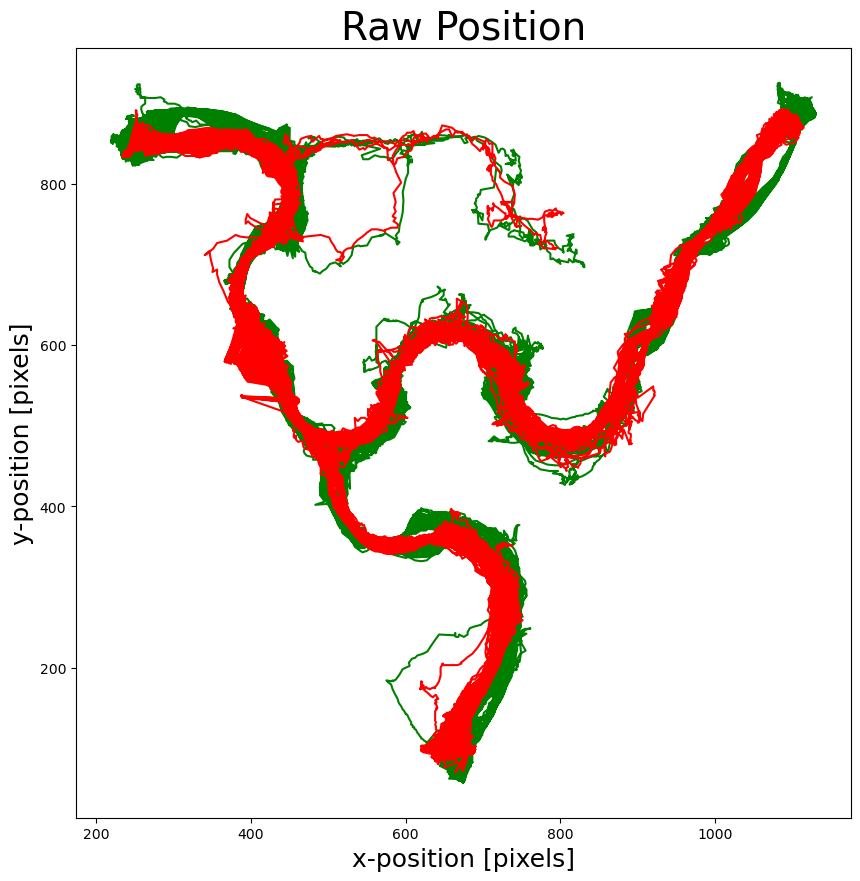

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(raw_position_df.xloc1, raw_position_df.yloc1, color="green")
# Uncomment for multiple LEDs
ax.plot(raw_position_df.xloc2, raw_position_df.yloc2, color="red")
ax.set_xlabel("x-position [pixels]", fontsize=18)
ax.set_ylabel("y-position [pixels]", fontsize=18)
ax.set_title("Raw Position", fontsize=28);

## Pairing interval and parameters


To associate a set of parameters with a given interval, insert them into the
`TrodesPosSelection` table.


In [ ]:
raw_position = (sgc.RawPosition.PosObject & {"nwb_file_name": nwb_copy_file_name, 'interval_list_name':interval_list_name})
spatial_series = raw_position.fetch_nwb()[1]["raw_position"]
spatial_series.conversion

print(spatial_series)

[2025-04-15 11:56:59,680][WARNING]: Skipped checksum for file with hash: 4ac633e3-ae66-dc7d-df56-1f19c562387d, and path: /stelmo/nwb/raw/BraveLu20240516_.nwb
[2025-04-15 11:56:59,687][WARNING]: Skipped checksum for file with hash: 4ac633e3-ae66-dc7d-df56-1f19c562387d, and path: /stelmo/nwb/raw/BraveLu20240516_.nwb


led_1_series_1 pynwb.behavior.SpatialSeries at 0x140637766439600
Fields:
  comments: no comments
  conversion: 0.0016
  data: <HDF5 dataset "data": shape (121697, 2), type "<u2">
  description: xloc, yloc
  interval: 1
  offset: 0.0
  reference_frame: Upper left corner of video frame
  resolution: -1.0
  timestamps: <HDF5 dataset "timestamps": shape (121697,), type "<f8">
  timestamps_unit: seconds
  unit: meters



In [21]:
# trodes_params_name = "default_lowerspeed"
# trodes_params_name = "default"
trodes_params_name = "default_decoding"

trodes_s_key = {
    "nwb_file_name": nwb_copy_file_name,
    "interval_list_name": interval_list_name,
    "trodes_pos_params_name": trodes_params_name,
}
sgp.v1.TrodesPosSelection.insert1(
    trodes_s_key,
    skip_duplicates=True,
)

# Check  if we've inserted the parameters correctly:
trodes_key = (sgp.v1.TrodesPosSelection() & trodes_s_key).fetch1("KEY")
trodes_key

{'nwb_file_name': 'IM-1478_20220725_.nwb',
 'interval_list_name': 'pos 0 valid times',
 'trodes_pos_params_name': 'default_decoding'}

## Running the pipeline


We can run the pipeline for our chosen interval/parameters by using the
`TrodesPosV1.populate`.


In [22]:
sgp.v1.TrodesPosV1.populate(trodes_key)

{'success_count': 0, 'error_list': []}

Each NWB file, interval, and parameter set is now associated with a new analysis file and object ID.


When we populatethe `TrodesPosV1` table, we automatically create an entry in the `PositionOutput` merge table.  
Since this table supports position information from multiple methods, it's best practive to access data through here. 

We can view the entry in this table:

In [36]:
from spyglass.position import PositionOutput

PositionOutput.TrodesPosV1 & trodes_key

merge_id,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,trodes_pos_params_name name for this set of parameters
d9340e97-103b-099a-ca4d-96f6d9340cdd,IM-1478_20220725_.nwb,pos 0 valid times,default_decoding


In [24]:
sgp.v1.TrodesPosV1() & {'nwb_file_name':nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,trodes_pos_params_name name for this set of parameters,analysis_file_name name of the file,position_object_id,orientation_object_id,velocity_object_id
IM-1478_20220725_.nwb,pos 0 valid times,default_decoding,IM-1478_20220725_JUGJJL764A.nwb,780511d7-0585-4ff4-a49c-0cde3da1559a,d041cbba-8b29-478d-b659-245f3568c059,1bfc8a99-77e7-451e-94cf-5701c298a822


In [75]:
###### Delete the position tables if they were incorrect.
# (sgp.v1.TrodesPosV1()&{'nwb_file_name':'BraveLu20240513_.nwb','trodes_pos_params_name':'default_speed35'}).cautious_delete()

To retrieve the results as a pandas DataFrame with time as the index, we use `PositionOutput.fetch1_dataframe`.
When doing so, we need to restric the merge table by the 

This dataframe has the following columns:

- `position_{x,y}`: X or Y position of the head in cm.
- `orientation`: Direction of the head relative to the bottom left corner
  in radians
- `velocity_{x,y}`: Directional change in head position over time in cm/s
- `speed`: the magnitude of the change in head position over time in cm/s


In [37]:
# get the merge id corresponding to our inserted trodes_key
merge_key = (PositionOutput.merge_get_part(trodes_key)).fetch1("KEY")
# use this to restrict PositionOutput and fetch the data
position_info = (PositionOutput & merge_key).fetch1_dataframe()
position_info


[11:59:32][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False


,position_x,position_y,orientation,velocity_x,velocity_y,speed
time,,,,,,
0.311375,NaN,NaN,NaN,NaN,NaN,NaN
0.313375,NaN,NaN,NaN,NaN,NaN,NaN
0.315375,NaN,NaN,NaN,NaN,NaN,NaN
0.317375,NaN,NaN,NaN,NaN,NaN,NaN
0.319375,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
5203.127088,29.949850,116.951076,-0.352008,0.274199,0.015577,0.274641
5203.129088,29.952332,116.951419,-0.352791,0.275171,0.015592,0.275612
5203.131088,29.954814,116.951763,-0.353578,0.275929,0.015607,0.276370


In [143]:
# Remove timepoints before rat was put on the maze
os.chdir("/home/xulu/code/Hex-maze-spyglass")
from hex_maze_behavior import HexMazeConfig, HexMazeBlock
start_time = (HexMazeBlock() & {'nwb_file_name':nwb_copy_file_name, 'epoch':epoch, 'block':1}).fetch('block_interval')[0][0]


## Examine results



### Plots



Let's plot some of the variables first:


Text(0.5, 1.0, 'Position')

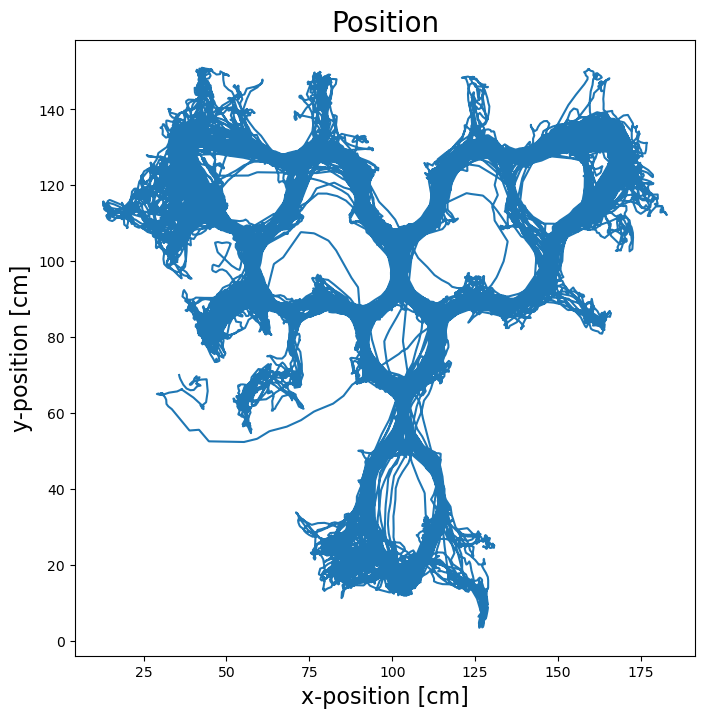

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(position_info.position_x, position_info.position_y)
ax.set_xlabel("x-position [cm]", fontsize=16)
ax.set_ylabel("y-position [cm]", fontsize=16)
ax.set_title("Position", fontsize=20)

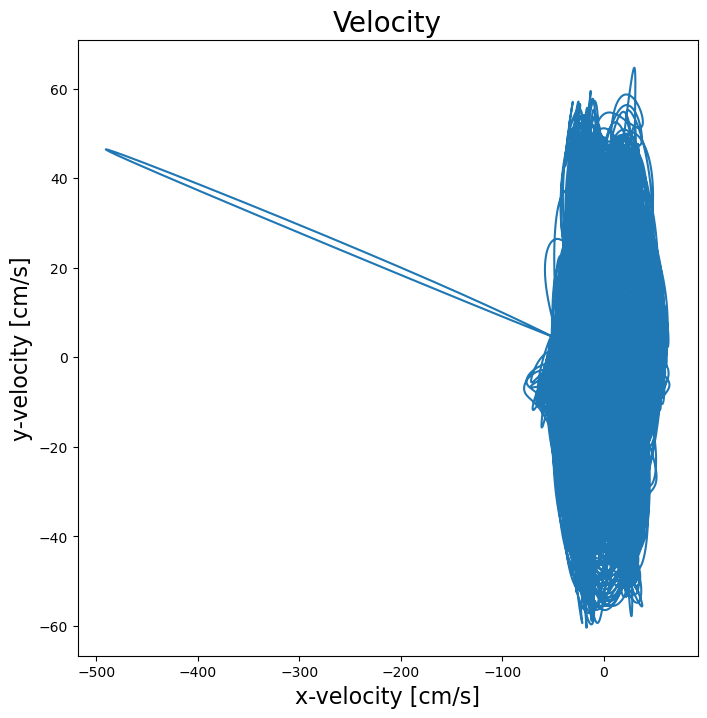

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(position_info.velocity_x, position_info.velocity_y)
ax.set_xlabel("x-velocity [cm/s]", fontsize=16)
ax.set_ylabel("y-velocity [cm/s]", fontsize=16)
ax.set_title("Velocity", fontsize=20);

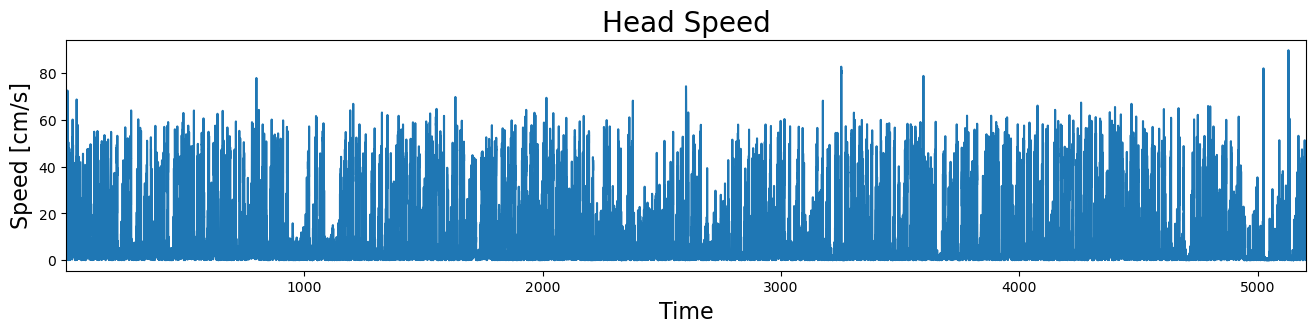

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(position_info.index, position_info.speed)
ax.set_xlabel("Time", fontsize=16)
ax.set_ylabel("Speed [cm/s]", fontsize=16)
ax.set_title("Head Speed", fontsize=20)
ax.set_xlim((position_info.index.min(), position_info.index.max()));

### Video

To keep `minirec` small, the download link does not include videos by default. 

If it is available, you can uncomment the code, populate the  `TrodesPosVideo` table, and plot the results on the video using the `make_video` function, which will appear in the current working directory.


In [19]:
# sgp.v1.TrodesPosVideo().populate(
#     {
#         "nwb_file_name": nwb_copy_file_name,
#         "interval_list_name": interval_list_name,
#         "position_info_param_name": trodes_params_name,
#     }
# )

In [20]:
# sgp.v1.TrodesPosVideo()

## Upsampling position

To get position data in smaller in time bins, we can upsample using the 
following parameters

- `is_upsampled`, default 0 (False): If 1, perform upsampling.
- `upsampling_sampling_rate`, default None: the rate to upsample to (e.g.,
  33 Hz video might be upsampled to 500 Hz).
- `upsampling_interpolation_method`, default linear: interpolation method. See
  [pandas.DataFrame.interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)
  for alternate methods.


In [21]:
trodes_params_up_name = trodes_params_name + "_upsampled"
trodes_params_up = {
    **trodes_params,
    "is_upsampled": 1,
    "upsampling_sampling_rate": 500,
}
sgp.v1.TrodesPosParams.insert1(
    {
        "trodes_pos_params_name": trodes_params_up_name,
        "params": trodes_params_up,
    },
    skip_duplicates=True,
)

sgp.v1.TrodesPosParams()

trodes_pos_params_name name for this set of parameters,params
default,=BLOB=
single_led,=BLOB=
single_led_upsampled,=BLOB=


In [22]:
trodes_s_up_key = {
    "nwb_file_name": nwb_copy_file_name,
    "interval_list_name": interval_list_name,
    "trodes_pos_params_name": trodes_params_up_name,
}
sgp.v1.TrodesPosSelection.insert1(
    trodes_s_up_key,
    skip_duplicates=True,
)
sgp.v1.TrodesPosV1.populate(trodes_s_up_key)

In [23]:
merge_key = (PositionOutput.merge_get_part(trodes_s_up_key)).fetch1("KEY")
upsampled_position_info = (PositionOutput & merge_key).fetch1_dataframe()
upsampled_position_info

[13:47:56][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
[2024-01-12 13:47:56,476][WARNING]: Skipped checksum for file with hash: 119a4889-1117-30a9-c774-3c7db7048f02, and path: /Users/edeno/Documents/GitHub/spyglass/DATA/analysis/minirec20230622/minirec20230622_PBPM9HN98Y.nwb


,position_x,position_y,orientation,velocity_x,velocity_y,speed
time,,,,,,
1.687475e+09,22.250000,28.350000,0.808756,-0.083265,0.082262,0.117047
1.687475e+09,22.250000,28.350000,0.905134,-0.084928,0.083888,0.119373
1.687475e+09,22.250000,28.350000,0.905373,-0.086591,0.085514,0.121699
1.687475e+09,22.250000,28.350000,0.905373,-0.088254,0.087138,0.124023
1.687475e+09,22.250000,28.350000,0.905373,-0.089915,0.088760,0.126345
...,...,...,...,...,...,...
1.687475e+09,24.029412,26.565686,0.835485,1.095035,-2.036613,2.312335
1.687475e+09,24.030392,26.561765,0.835391,1.070802,-1.998650,2.267425
1.687475e+09,24.031373,26.557843,0.835298,1.046820,-1.960860,2.222792


Text(0.5, 1.0, 'Upsampled Position')

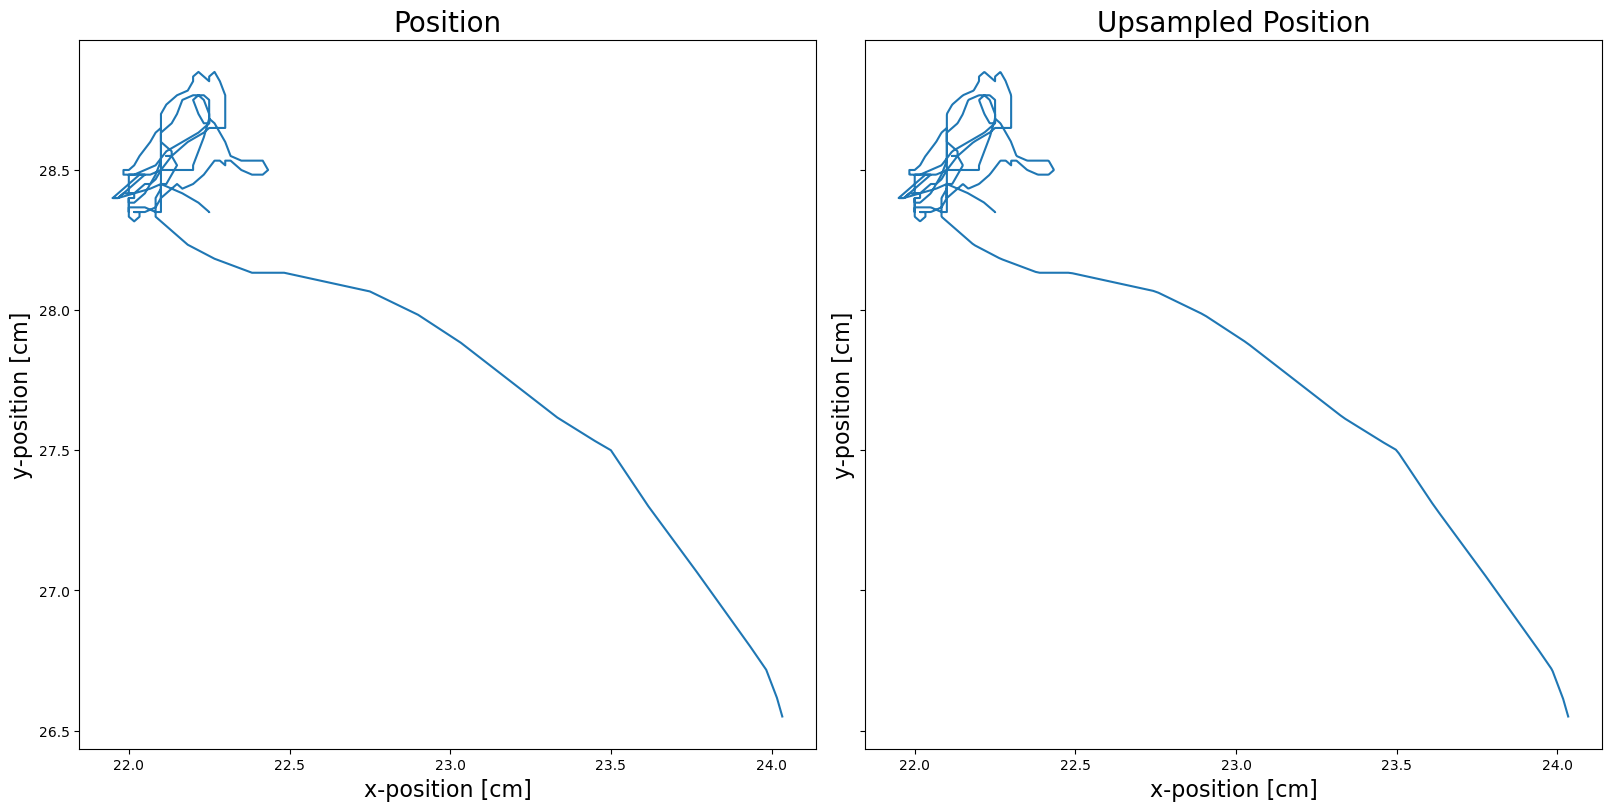

In [24]:
fig, axes = plt.subplots(
    1, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True
)
axes[0].plot(position_info.position_x, position_info.position_y)
axes[0].set_xlabel("x-position [cm]", fontsize=16)
axes[0].set_ylabel("y-position [cm]", fontsize=16)
axes[0].set_title("Position", fontsize=20)

axes[1].plot(
    upsampled_position_info.position_x,
    upsampled_position_info.position_y,
)
axes[1].set_xlabel("x-position [cm]", fontsize=16)
axes[1].set_ylabel("y-position [cm]", fontsize=16)
axes[1].set_title("Upsampled Position", fontsize=20)

Text(0.5, 1.0, 'Upsampled Speed')

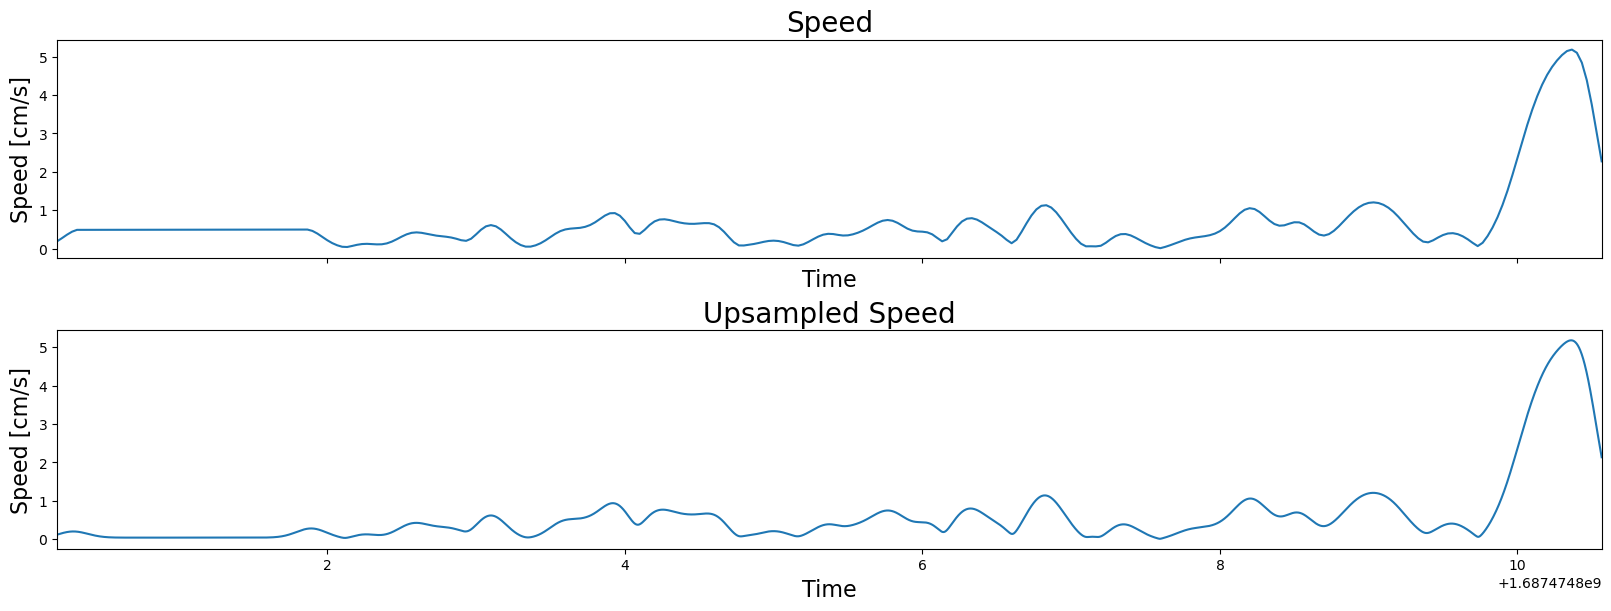

In [25]:
fig, axes = plt.subplots(
    2, 1, figsize=(16, 6), sharex=True, sharey=True, constrained_layout=True
)
axes[0].plot(position_info.index, position_info.speed)
axes[0].set_xlabel("Time", fontsize=16)
axes[0].set_ylabel("Speed [cm/s]", fontsize=16)
axes[0].set_title("Speed", fontsize=20)
axes[0].set_xlim((position_info.index.min(), position_info.index.max()))

axes[1].plot(upsampled_position_info.index, upsampled_position_info.speed)
axes[1].set_xlabel("Time", fontsize=16)
axes[1].set_ylabel("Speed [cm/s]", fontsize=16)
axes[1].set_title("Upsampled Speed", fontsize=20)

Text(0.5, 1.0, 'Upsampled Velocity')

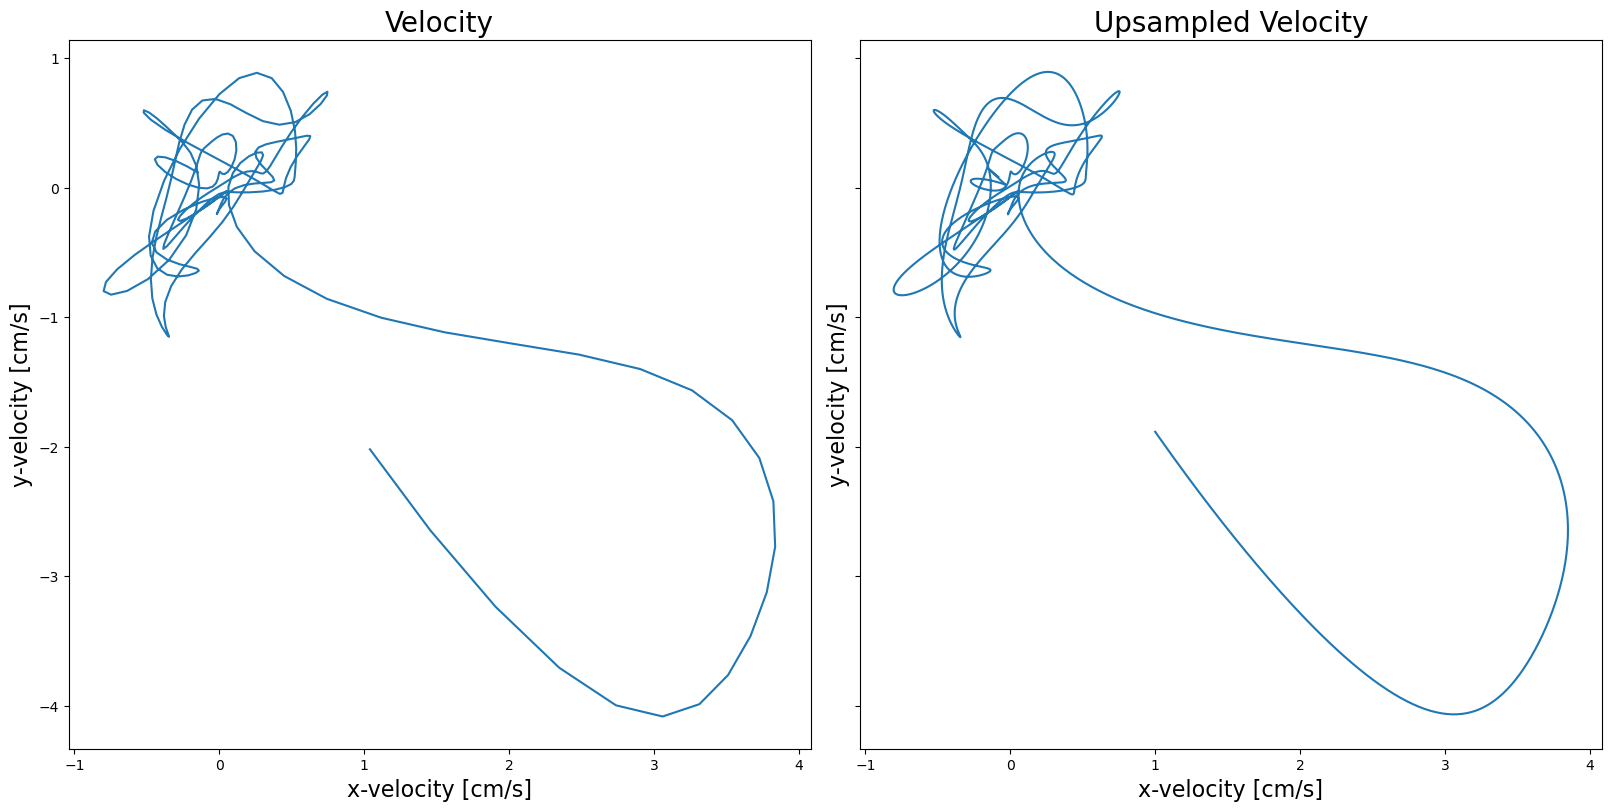

In [26]:
fig, axes = plt.subplots(
    1, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True
)
axes[0].plot(position_info.velocity_x, position_info.velocity_y)
axes[0].set_xlabel("x-velocity [cm/s]", fontsize=16)
axes[0].set_ylabel("y-velocity [cm/s]", fontsize=16)
axes[0].set_title("Velocity", fontsize=20)

axes[1].plot(
    upsampled_position_info.velocity_x,
    upsampled_position_info.velocity_y,
)
axes[1].set_xlabel("x-velocity [cm/s]", fontsize=16)
axes[1].set_ylabel("y-velocity [cm/s]", fontsize=16)
axes[1].set_title("Upsampled Velocity", fontsize=20)

## Up Next

In the [next notebook](./21_Position_DLC_1.ipynb), we'll explore using DeepLabCut to generate position data from video.
